# Ingest and View Data

In [1]:
import pandas as pd
from sqlalchemy import create_engine

In [2]:
POSTGRES_USERNAME = 'root'
POSTGRES_PASSWORD = 'koBREipm4h7CuRKix2Tn'
POSTGRES_HOSTNAME = 'database-1.c3ma8u2guxxs.us-east-2.rds.amazonaws.com'
POSTGRES_PORT = '5432'
POSTGRES_DBNAME = 'postgres'

connection_string = f"postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_HOSTNAME}:{POSTGRES_PORT}/{POSTGRES_DBNAME}"
engine = create_engine(connection_string)

In [3]:
query = """
SELECT * FROM darwin
"""

df = pd.read_sql(query, engine)

In [4]:
df.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_pass,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,...,platform,train_length,estimated_time,source,actual_time,actual_time_class,is_delayed_arrival,is_delayed_departure,source_instance,estimated_time_minutes
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,None,19:31:00,19:31:30,19:31:00,19:31:00,...,4,10.0,None,None,None,None,False,False,None,None
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,None,19:37:00,19:38:00,19:37:00,19:38:00,...,A,NaN,None,None,None,None,False,False,None,None
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,None,19:30:30,19:31:00,19:31:00,19:31:00,...,2,NaN,None,None,None,None,False,False,None,None
3,202407036735756,C35756,2024-07-03,TD,BRMB,None,19:33:00,19:33:30,19:33:00,19:33:00,...,1,NaN,None,None,None,None,False,False,None,None
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,None,19:35:00,19:35:30,19:35:00,19:35:00,...,2,NaN,None,None,None,None,False,False,None,None


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                91475 non-null  object 
 1   unique_id               91475 non-null  object 
 2   service_start_date      91475 non-null  object 
 3   update_origin           89375 non-null  object 
 4   train_platform          91475 non-null  object 
 5   working_time_pass       0 non-null      object 
 6   working_time_arrival    91475 non-null  object 
 7   working_time_departure  91475 non-null  object 
 8   planned_time_arrival    85695 non-null  object 
 9   planned_time_departure  85531 non-null  object 
 10  actual_arrival_time     78457 non-null  object 
 11  actual_departure_time   86025 non-null  object 
 12  platform                86645 non-null  object 
 13  train_length            30051 non-null  float64
 14  estimated_time          0 non-null    

# Clean DF 
**Drop Null Columns and Unnecessary Columns**

In [6]:
# columns to drop due to null values
columns_to_drop = [
    'working_time_pass',
    'estimated_time',
    'source',
    'actual_time',
    'actual_time_class',
    'source_instance',
    'estimated_time_minutes',
    'train_length'            
]

df_cleaned = df.drop(columns=columns_to_drop)

In [7]:
# check duplicates
duplicates = df_cleaned.duplicated().sum()
duplicates

4521

In [8]:
# to drop duplicates
# df_clean = df_clean.drop_duplicates()

In [9]:
# check nulls
df_cleaned.isna().sum()

route_id                      0
unique_id                     0
service_start_date            0
update_origin              2100
train_platform                0
working_time_arrival          0
working_time_departure        0
planned_time_arrival       5780
planned_time_departure     5944
actual_arrival_time       13018
actual_departure_time      5450
platform                   4830
is_delayed_arrival            0
is_delayed_departure          0
dtype: int64

In [10]:
# to drop remaining nulls
# df_cleaned = df_cleaned.dropna()

# Delay DF

In [11]:
query_delay = "SELECT * FROM darwin WHERE is_delayed_arrival = True AND is_delayed_departure = True"
df_delay = pd.read_sql(query_delay, engine)

In [12]:
df_delay = df_delay.drop(columns=columns_to_drop)

In [13]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7407 entries, 0 to 7406
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   route_id                7407 non-null   object
 1   unique_id               7407 non-null   object
 2   service_start_date      7407 non-null   object
 3   update_origin           7407 non-null   object
 4   train_platform          7407 non-null   object
 5   working_time_arrival    7407 non-null   object
 6   working_time_departure  7407 non-null   object
 7   planned_time_arrival    4113 non-null   object
 8   planned_time_departure  4103 non-null   object
 9   actual_arrival_time     7403 non-null   object
 10  actual_departure_time   7393 non-null   object
 11  platform                5441 non-null   object
 12  is_delayed_arrival      7407 non-null   bool  
 13  is_delayed_departure    7407 non-null   bool  
dtypes: bool(2), object(12)
memory usage: 709.0+ KB


In [14]:
df_delay.duplicated().sum()

49

# Adding Duration Column
Convert times from object datatypes to time datatypes.

In [15]:
df_cleaned['working_time_arrival'] = pd.to_datetime(df_cleaned['working_time_arrival'], format='%H:%M:%S')
df_cleaned['working_time_departure'] = pd.to_datetime(df_cleaned['working_time_departure'], format='%H:%M:%S')

Complete math to find duration.

In [16]:
df_cleaned['duration (min)'] = ((df_cleaned['working_time_departure']-df_cleaned['working_time_arrival'])\
                                .dt.total_seconds()/60)

Transition back to time only.

In [17]:
df_cleaned['working_time_arrival'] = df_cleaned['working_time_arrival'].dt.time
df_cleaned['working_time_departure'] = df_cleaned['working_time_departure'].dt.time

Repeat for Delay Dataframe.

In [18]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

# Ingest Rail References Data

In [19]:
reference_df = pd.read_csv('./raw_data/RailReferences.csv')

## Convert Easting, Northing to Latitude and Longitude

In [20]:
!pip install pyproj

In [21]:
from pyproj import Transformer

In [22]:
#  Define the British National Grid projection (EPSG:27700) and WGS84
osgb_projection = 'epsg:27700'  # British National Grid
wgs84_projection = 'epsg:4326'  # WGS84

In [23]:
# Initialize the transformer
transformer = Transformer.from_crs(osgb_projection, wgs84_projection)

In [24]:
# Function to convert British National Grid to latitude and longitude
def convert_osgb_to_latlong(easting, northing):
    longitude, latitude = transformer.transform(easting, northing)
    return longitude, latitude

In [25]:
# Apply conversion to the DataFrame and create new columns Latitude and Longitude
reference_df[['Latitude', 'Longitude']] = reference_df.apply(lambda row: convert_osgb_to_latlong(row['Easting'], row['Northing']),\
                                         axis=1,\
                                         result_type='expand')

In [26]:
# Data need for analysis 
data = reference_df[['TiplocCode', 'StationName', 'Latitude', 'Longitude']]
data

,TiplocCode,StationName,Latitude,Longitude
0,PENZNCE,Penzance Rail Station,50.121672,-5.532565
1,STIVES,St Ives (Cornwall) Rail Station,50.209043,-5.477912
2,CARBISB,Carbis Bay Rail Station,50.197048,-5.463263
3,STERTH,St Erth Rail Station,50.170489,-5.444252
4,LELANTS,Lelant Saltings Rail Station,50.178775,-5.440926
...,...,...,...,...
2623,SMRLYTN,Somerleyton Rail Station,52.510229,1.652260
2624,OULTNBS,Oulton Broad South Rail Station,52.469602,1.707659
2625,YARMTH,Great Yarmouth Rail Station,52.612158,1.720886
2626,OULTNBN,Oulton Broad North Rail Station,52.477759,1.715711


### Data Enrichment
Used this section to add identifying information for top Timing Point Locations (*TiplocCode*) not already identified in the supplied "RailReferences.csv" data. 

Research indicates that the Timing Point Location for BONDST, correlates to Bond Street Station$^{1}$ located at 51.514°N, 0.15°W$^{2}$. 

In [27]:
new_row = pd.DataFrame([['BONDST', 'Bond Street Station', 51.514, -0.15]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for TOTCTRD, correlates to Tottenham Court Road$^{1}$ located at 51.5207°N, 0.1345°W$^{3}$. 

In [28]:
new_row = pd.DataFrame([['TOTCTRD', 'Tottenham Court Road', 51.5207, -0.1345]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for CANWHRF, correlates to Canary Wharf Railway Station$^{1}$ located at 51.5061°N, 0.01578°W$^{4}$. 

In [29]:
new_row = pd.DataFrame([['CANWHRF', 'Canary Wharf Railway Station', 51.5061, -0.01578]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for WCHAPXR, correlates to Whitechapel Crossrail$^{1}$ located at 51.5195°N, 0.0612°W$^{5, 6}$. 

In [30]:
new_row = pd.DataFrame([['WCHAPXR', 'Whitechapel Crossrail', 51.9195, -0.0612]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

Research indicates that the Timing Point Location for LIVSTLL, correlates to London Liverpool Street Crossrail$^{1}$ located at 51.5186°N, 0.0813°W$^{6, 7}$. 

In [31]:
new_row = pd.DataFrame([['LIVSTLL', 'London Liverpool Street Crossrail', 51.5186, -0.0813]], columns=data.columns)
data = pd.concat([data, new_row], ignore_index=True)

### Bibliography

1. http://www.railwaycodes.org.uk/crs/crsb.shtm

2. https://en.wikipedia.org/wiki/Bond_Street_station

3. https://en.wikipedia.org/wiki/Tottenham_Court_Road

4. https://en.wikipedia.org/wiki/Canary_Wharf_railway_station

5. https://en.wikipedia.org/wiki/Whitechapel_station

6. https://en.wikipedia.org/wiki/Crossrail

7. https://en.wikipedia.org/wiki/Liverpool_Street_station

## Using Rail References to Replace Train Platform with Station Name

In [32]:
# Merge df_cleaned with data columns from reference_df

df_merged = df_cleaned.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [33]:
# checking where train_platform has no related StationName/Tiploccode
nan_rows = df_merged[df_merged[['TiplocCode', 'StationName']].isna().any(axis=1)]

nan_rows[['train_platform', 'TiplocCode', 'StationName']]

,train_platform,TiplocCode,StationName
16,WOLWXR,NaN,NaN
23,FRMPKRS,NaN,NaN
24,HRNS451,NaN,NaN
25,BOWERRL,NaN,NaN
52,CMRNBDG,NaN,NaN
...,...,...,...
91308,FRNDXR,NaN,NaN
91319,PADTLL,NaN,NaN
91322,FRNDXR,NaN,NaN
91324,FRNDXR,NaN,NaN


In [34]:
# Identifying most highly frequented unknown Station Names
station_NaN = df_merged[df_merged['StationName'].isna()]['train_platform'].value_counts()
station_NaN.head(20)

train_platform
FRNDXR     302
PADTLL     182
CUSTMHS    181
WOLWXR     176
STALBCS    120
BRENTX     117
MAGHNTH    113
CNNBELL     64
BOWERRL     62
LTCEADL     61
STDI        57
MLLF        57
LTCEREC     55
PALL        54
FELL        54
UNIV        50
CLPHMYM     48
CIVI        48
PELAWTW     47
CRKLREC     46
Name: count, dtype: int64

In [35]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_merged['StationName'] = df_merged['StationName'].fillna(df_merged['train_platform'])

# Drop TiplocCode to avoid redundency
# df_merged.drop(columns=['TiplocCode'], inplace=True)

# Replace 'Rail Station' with an empty string to make more readable
df_merged['StationName'] = df_merged['StationName'].str.replace(' Rail Station', '')

In [36]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91475 entries, 0 to 91474
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                91475 non-null  object 
 1   unique_id               91475 non-null  object 
 2   service_start_date      91475 non-null  object 
 3   update_origin           89375 non-null  object 
 4   train_platform          91475 non-null  object 
 5   working_time_arrival    91475 non-null  object 
 6   working_time_departure  91475 non-null  object 
 7   planned_time_arrival    85695 non-null  object 
 8   planned_time_departure  85531 non-null  object 
 9   actual_arrival_time     78457 non-null  object 
 10  actual_departure_time   86025 non-null  object 
 11  platform                86645 non-null  object 
 12  is_delayed_arrival      91475 non-null  bool   
 13  is_delayed_departure    91475 non-null  bool   
 14  duration (min)          91475 non-null

# Delays

In [37]:
df_delay = df_delay.merge(data, left_on='train_platform', right_on='TiplocCode', how='left')

In [38]:
# fill NaN values in the StationName column with the corresponding train_platform values
df_delay['StationName'] = df_delay['StationName'].fillna(df_delay['train_platform'])

# Replace 'Rail Station' with an empty string to make more readable
df_delay['StationName'] = df_delay['StationName'].str.replace(' Rail Station', '')

df_delay

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,19:22:00,19:28:00,19:21:00,19:28:00,19:32:00,19:33:00,1,True,True,6.0,GLOSTER,Gloucester,51.865557,-2.238488
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,19:24:00,19:35:30,None,None,19:33:00,19:34:00,None,True,True,11.5,NaN,LADYBHL,NaN,NaN
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,19:26:30,19:27:30,19:27:00,19:27:00,19:35:00,19:35:00,2,True,True,1.0,CRAWLEY,Crawley,51.112212,-0.186673
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,19:29:30,19:30:00,19:30:00,19:30:00,19:37:00,19:38:00,2,True,True,0.5,IFIELD,Ifield,51.115621,-0.214772
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,19:33:30,19:34:00,19:34:00,19:34:00,19:41:00,19:42:00,2,True,True,0.5,FAYGATE,Faygate,51.095889,-0.263019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7402,202407096785472,C85472,2024-07-09,CIS,WOLWXR,18:40:30,18:41:00,18:41:00,18:41:00,18:43:00,18:43:00,A,True,True,0.5,NaN,WOLWXR,NaN,NaN
7403,202407096785472,C85472,2024-07-09,CIS,LIVSTLL,18:25:30,18:26:30,18:26:00,18:26:00,18:28:00,18:29:00,A,True,True,1.0,LIVSTLL,London Liverpool Street Crossrail,51.518600,-0.081300
7404,202407096785472,C85472,2024-07-09,CIS,CUSTMHS,18:36:00,18:37:00,18:36:00,18:37:00,18:38:00,18:39:00,A,True,True,1.0,NaN,CUSTMHS,NaN,NaN
7405,202407096785472,C85472,2024-07-09,CIS,FRNDXR,18:23:00,18:24:00,18:23:00,18:24:00,18:26:00,18:27:00,A,True,True,1.0,NaN,FRNDXR,NaN,NaN


In [39]:
df_delay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7407 entries, 0 to 7406
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   route_id                7407 non-null   object 
 1   unique_id               7407 non-null   object 
 2   service_start_date      7407 non-null   object 
 3   update_origin           7407 non-null   object 
 4   train_platform          7407 non-null   object 
 5   working_time_arrival    7407 non-null   object 
 6   working_time_departure  7407 non-null   object 
 7   planned_time_arrival    4113 non-null   object 
 8   planned_time_departure  4103 non-null   object 
 9   actual_arrival_time     7403 non-null   object 
 10  actual_departure_time   7393 non-null   object 
 11  platform                5441 non-null   object 
 12  is_delayed_arrival      7407 non-null   bool   
 13  is_delayed_departure    7407 non-null   bool   
 14  duration (min)          7407 non-null   

Determine the minutes delayed.

In [40]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['duration (min)'] = ((df_delay['working_time_departure']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)
df_delay['working_time_arrival'] = df_delay['working_time_arrival'].dt.time
df_delay['working_time_departure'] = df_delay['working_time_departure'].dt.time

In [41]:
df_delay['working_time_arrival'] = pd.to_datetime(df_delay['working_time_arrival'], format='%H:%M:%S')
df_delay['working_time_departure'] = pd.to_datetime(df_delay['working_time_departure'], format='%H:%M:%S')
df_delay['actual_arrival_time'] = pd.to_datetime(df_delay['actual_arrival_time'], format='%H:%M:%S')
df_delay['actual_departure_time'] = pd.to_datetime(df_delay['actual_departure_time'], format='%H:%M:%S')

In [42]:
df_delay['depart_delay(min)'] = ((df_delay['actual_departure_time']-df_delay['working_time_departure'])\
                                .dt.total_seconds()/60)

In [43]:
df_delay['arrive_delay(min)'] = ((df_delay['actual_arrival_time']-df_delay['working_time_arrival'])\
                                .dt.total_seconds()/60)

In [44]:
df_delay.describe()

,working_time_arrival,working_time_departure,actual_arrival_time,actual_departure_time,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,7407,7407,7403,7393,7407.000000,5598.000000,5598.000000,7393.000000,7403.000000
mean,1900-01-01 14:00:32.539084544,1900-01-01 14:03:40.916970496,1900-01-01 14:48:12.813724160,1900-01-01 14:48:19.494116352,3.139631,52.656897,-1.292975,45.125091,47.744435
min,1900-01-01 00:03:00,1900-01-01 00:03:30,1900-01-01 00:10:00,1900-01-01 00:00:00,0.000000,50.377826,-4.996328,-1414.500000,-1413.500000
25%,1900-01-01 12:11:00,1900-01-01 12:12:30,1900-01-01 13:33:00,1900-01-01 13:33:00,0.500000,51.533964,-2.268989,6.000000,7.500000
50%,1900-01-01 15:52:30,1900-01-01 15:53:30,1900-01-01 16:43:00,1900-01-01 16:43:00,1.000000,51.971160,-0.885869,29.500000,32.000000
75%,1900-01-01 18:58:30,1900-01-01 19:01:00,1900-01-01 19:45:00,1900-01-01 19:46:00,3.000000,53.602031,-0.171367,73.000000,77.000000
max,1900-01-01 23:57:00,1900-01-01 23:58:00,1900-01-01 23:59:00,1900-01-01 23:47:00,128.500000,57.188510,1.707659,1320.500000,1320.500000
std,NaN,NaN,NaN,NaN,6.047890,1.468542,1.397793,65.477704,63.630267


We can see that the math in the previous step created some erroneous values (minimum of depart_delay(min) is negative.) This will occur in cases where there is no reported actual_departure_time. We will get the value zero where the train is not delayed. We will define a function to remove delays less than or equal to zero.

In [45]:
def remove_neg_and_zero(delay):
    if delay <= 0:
        delay = None
    else:
        delay = delay
    return delay

In [46]:
df_delay['depart_delay(min)'] = df_delay['depart_delay(min)'].apply(remove_neg_and_zero)

In [47]:
df_delay['arrive_delay(min)'] = df_delay['arrive_delay(min)'].apply(remove_neg_and_zero)

In [48]:
df_delay.describe()

,working_time_arrival,working_time_departure,actual_arrival_time,actual_departure_time,duration (min),Latitude,Longitude,depart_delay(min),arrive_delay(min)
count,7407,7407,7403,7393,7407.000000,5598.000000,5598.000000,6591.000000,7006.000000
mean,1900-01-01 14:00:32.539084544,1900-01-01 14:03:40.916970496,1900-01-01 14:48:12.813724160,1900-01-01 14:48:19.494116352,3.139631,52.656897,-1.292975,52.424412,51.585719
min,1900-01-01 00:03:00,1900-01-01 00:03:30,1900-01-01 00:10:00,1900-01-01 00:00:00,0.000000,50.377826,-4.996328,0.500000,0.500000
25%,1900-01-01 12:11:00,1900-01-01 12:12:30,1900-01-01 13:33:00,1900-01-01 13:33:00,0.500000,51.533964,-2.268989,10.000000,9.000000
50%,1900-01-01 15:52:30,1900-01-01 15:53:30,1900-01-01 16:43:00,1900-01-01 16:43:00,1.000000,51.971160,-0.885869,38.000000,36.500000
75%,1900-01-01 18:58:30,1900-01-01 19:01:00,1900-01-01 19:45:00,1900-01-01 19:46:00,3.000000,53.602031,-0.171367,80.000000,79.500000
max,1900-01-01 23:57:00,1900-01-01 23:58:00,1900-01-01 23:59:00,1900-01-01 23:47:00,128.500000,57.188510,1.707659,1320.500000,1320.500000
std,NaN,NaN,NaN,NaN,6.047890,1.468542,1.397793,56.117114,56.374286


In [49]:
# export delay routes csv
df_delay.to_csv('./cleaned_data/delay_durations.csv', index=False, mode = 'w+')

## Calculate Delay Duration
Take the data where we are able to calucate delays.

In [50]:
df_delay.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,...,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,depart_delay(min),arrive_delay(min)
0,202407037144581,G44581,2024-07-03,Darwin,GLOSTER,1900-01-01 19:22:00,1900-01-01 19:28:00,19:21:00,19:28:00,1900-01-01 19:32:00,...,1,True,True,6.0,GLOSTER,Gloucester,51.865557,-2.238488,5.0,10.0
1,202407036707715,C07715,2024-07-03,Darwin,LADYBHL,1900-01-01 19:24:00,1900-01-01 19:35:30,None,None,1900-01-01 19:33:00,...,None,True,True,11.5,NaN,LADYBHL,NaN,NaN,NaN,9.0
2,202407037154103,G54103,2024-07-03,Darwin,CRAWLEY,1900-01-01 19:26:30,1900-01-01 19:27:30,19:27:00,19:27:00,1900-01-01 19:35:00,...,2,True,True,1.0,CRAWLEY,Crawley,51.112212,-0.186673,7.5,8.5
3,202407037154103,G54103,2024-07-03,Darwin,IFIELD,1900-01-01 19:29:30,1900-01-01 19:30:00,19:30:00,19:30:00,1900-01-01 19:37:00,...,2,True,True,0.5,IFIELD,Ifield,51.115621,-0.214772,8.0,7.5
4,202407037154103,G54103,2024-07-03,Darwin,FAYGATE,1900-01-01 19:33:30,1900-01-01 19:34:00,19:34:00,19:34:00,1900-01-01 19:41:00,...,2,True,True,0.5,FAYGATE,Faygate,51.095889,-0.263019,8.0,7.5


In [51]:
# Create the 'delayed' column
df_merged['delayed'] = df_merged['is_delayed_arrival'] | df_merged['is_delayed_departure']

# Check
df_merged.head()

,route_id,unique_id,service_start_date,update_origin,train_platform,working_time_arrival,working_time_departure,planned_time_arrival,planned_time_departure,actual_arrival_time,actual_departure_time,platform,is_delayed_arrival,is_delayed_departure,duration (min),TiplocCode,StationName,Latitude,Longitude,delayed
0,202407037139232,G39232,2024-07-03,TD,SCROYDN,19:31:00,19:31:30,19:31:00,19:31:00,None,19:32:00,4,False,False,0.5,SCROYDN,South Croydon,51.362963,-0.093457,False
1,202407036785172,C85172,2024-07-03,CIS,LIVSTLL,19:37:00,19:38:00,19:37:00,19:38:00,19:37:00,19:38:00,A,False,False,1.0,LIVSTLL,London Liverpool Street Crossrail,51.518600,-0.081300,False
2,202407036735756,C35756,2024-07-03,TD,ESTHRAK,19:30:30,19:31:00,19:31:00,19:31:00,None,None,2,False,False,0.5,ESTHRAK,Eastham Rake,53.307537,-2.981132,False
3,202407036735756,C35756,2024-07-03,TD,BRMB,19:33:00,19:33:30,19:33:00,19:33:00,19:33:00,19:33:00,1,False,False,0.5,BRMB,Bromborough,53.321845,-2.986895,False
4,202407036735756,C35756,2024-07-03,TD,BRMBRK,19:35:00,19:35:30,19:35:00,19:35:00,19:35:00,19:35:00,2,False,False,0.5,BRMBRK,Bromborough Rake,53.329905,-2.989469,False


## Delays  by Route

In [52]:
# Extract the necessary columns
df_extracted = df_merged[['route_id', 'delayed']]

# Calculate the count of delays for each route_id and TiplocCode
delay_counts_by_route = df_extracted.groupby('route_id')['delayed'].sum().reset_index()
delay_counts_by_route.rename(columns={'delayed': 'delay_counts_by_route'}, inplace=True)

# Calculate the total count of records for each route_id and TiplocCode
total_counts_by_route = df_extracted.groupby('route_id')['route_id'].count().reset_index(name='total_counts_by_route')

# Merge the delay counts and total counts
delay_summary = delay_counts_by_route.merge(total_counts_by_route, on='route_id')

# Calculate the % delayed for each route_id
delay_summary['%_delayed_by_route'] = (delay_summary['delay_counts_by_route'] / delay_summary['total_counts_by_route']) * 100

# Select the relevant columns
delays_by_route = delay_summary[['route_id', 'delay_counts_by_route', 'total_counts_by_route', '%_delayed_by_route']]

# Check
delays_by_route

,route_id,delay_counts_by_route,total_counts_by_route,%_delayed_by_route
0,202407036704095,0,1,0.000000
1,202407036704542,0,1,0.000000
2,202407036705093,1,7,14.285714
3,202407036705096,0,13,0.000000
4,202407036705102,0,5,0.000000
...,...,...,...,...
20533,202407098903774,0,3,0.000000
20534,202407098904019,0,5,0.000000
20535,202407098905768,0,2,0.000000
20536,202407098905794,0,1,0.000000


In [53]:
# export delay routes csv
delays_route = delays_by_route.to_csv('./cleaned_data/delays_by_route.csv', index=False, mode = 'w+')

## Delays by Station Name

In [54]:
df_extracted2 = df_merged[['StationName', 'TiplocCode', 'delayed', 'Latitude', 'Longitude']]

# Calculate the count of delays for each StationName
delay_counts_by_station = df_extracted2.groupby('StationName')['delayed'].sum().reset_index()
delay_counts_by_station.rename(columns={'delayed': 'delay_counts_by_station'}, inplace=True)

# Calculate the total count of records for each StationName
total_counts_by_station = df_extracted2.groupby('StationName')['StationName'].count().reset_index(name='total_counts_by_station')

# Merge the delay counts and total counts
delay_summary_station = delay_counts_by_station.merge(total_counts_by_station, on='StationName')

# Calculate the % delayed for each StationName
delay_summary_station['%_delayed_by_station'] = (delay_summary_station['delay_counts_by_station'] / delay_summary_station['total_counts_by_station']) * 100

# Select the relevant columns
delays_by_station = delay_summary_station[['StationName', 'delay_counts_by_station', 'total_counts_by_station', '%_delayed_by_station']]

# Merge the dataframes on 'StationName' to add latitude and longitude
delays_by_station = pd.merge(delays_by_station, df_extracted2[['StationName', 'TiplocCode', 'Latitude', 'Longitude']].drop_duplicates(), on='StationName', how='left')

# Check
delays_by_station

,StationName,delay_counts_by_station,total_counts_by_station,%_delayed_by_station,TiplocCode,Latitude,Longitude
0,ABHLJN,8,25,32.000000,NaN,NaN,NaN
1,ABRD27,0,1,0.000000,NaN,NaN,NaN
2,ALERTN4,3,3,100.000000,NaN,NaN,NaN
3,ALSTONS,6,13,46.153846,NaN,NaN,NaN
4,ARBRUNS,0,2,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2801,Yoker,2,61,3.278689,YOKER,55.892585,-4.386287
2802,York,76,394,19.289340,YORK,53.957964,-1.093182
2803,Yorton,0,2,0.000000,YORTON,52.808955,-2.736461
2804,Ystrad Mynach,2,44,4.545455,YSTRADM,51.640933,-3.241295


In [55]:
# exporting delays by station to csv
delay_stations = delays_by_station.to_csv('./cleaned_data/delays_by_station.csv', index=False, mode = 'w+')

In [56]:
# check how is_delayed arrivals/departures compare with delayed column
df_merged['is_delayed_arrival'].value_counts()

is_delayed_arrival
False    84068
True      7407
Name: count, dtype: int64

In [57]:
df_merged['is_delayed_departure'].value_counts()

is_delayed_departure
False    83752
True      7723
Name: count, dtype: int64

In [58]:
df_merged['delayed'].value_counts()

delayed
False    83752
True      7723
Name: count, dtype: int64

Delayed column has same counts as is_delayed_departure. 

# Value Counts for Analysis 

In [59]:
df_merged['service_start_date'].value_counts()

service_start_date
2024-07-05    26206
2024-07-09    18021
2024-07-04    13486
2024-07-08    11661
2024-07-06    10258
2024-07-07     8225
2024-07-03     3610
2024-07-10        8
Name: count, dtype: int64

In [60]:
# most popular routes
df_merged['route_id'].value_counts()

route_id
202407047154179    141
202407046748489     96
202407047513588     92
202407057513588     91
202407076785195     84
                  ... 
202407087656966      1
202407088093160      1
202407058078965      1
202407086722077      1
202407096733189      1
Name: count, Length: 20538, dtype: int64

In [61]:
df_merged['StationName'].value_counts()

StationName
London Bridge                         653
Clapham Junction                      542
York                                  394
East Croydon                          382
London St Pancras International LL    343
                                     ... 
THRNTSJ                                 1
CAMB177                                 1
Bordesley                               1
Braystones                              1
Golf Street                             1
Name: count, Length: 2796, dtype: int64

# Visuals 

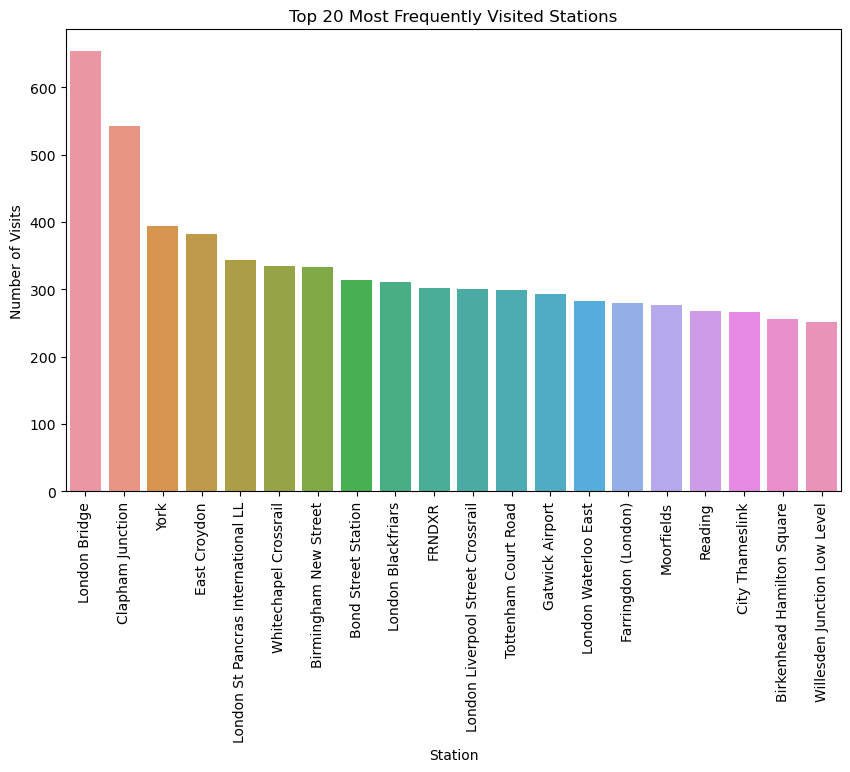

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
# Top 10 most frequently visited stations
top_stations = df_merged['StationName'].value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_stations.index, y=top_stations.values)
plt.title('Top 20 Most Frequently Visited Stations')
plt.xlabel('Station')
plt.ylabel('Number of Visits')
plt.xticks(rotation=90)
plt.show()

# Export Desired Dataframe

In [64]:
output = df_merged.to_csv('./cleaned_data/UK_Rail_Data.csv', index=False, mode = 'w+')